In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/nlp/
!pip3 install -e . -q
!pip3 install fastai==2.5.2 -q
!pip3 install nbdev -q 
!pip3 install datasets -q
!pip3 install transformers -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nlp
     |████████████████████████████████| 186 kB 35.4 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.8 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
     |███████████████

In [ ]:
#default_exp task.text_sim

In [27]:
#export
from nlp.data.external import load_medical_questions_pair
from fastai.text.all   import *
from inspect           import signature

## Tokenizer

In [ ]:
#hide
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
#hide
train.iloc[0, 2]

'I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?'

In [50]:
#hide
encoded_dict = tokenizer('After how many hour from drinking an antibiotic can I drink alcohol?', 
                         'I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?')

In [51]:
#hide
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## How could we use huggingface tokenizer in FastAI dataset creation?

In [33]:
#hide
sample_df = pd.DataFrame({'q1': ['This is a story', 'This is not a story', 'Alas we are all here', 'Here we go'],
                          'q2': ['Have you sold your soul?', 'What does this tell you', 'Glad we could reach here?', 'We can not go'],
                          'label': [0, 1, 1, 0]
                          })

sample_df.head()

,q1,q2,label
0,This is a story,Have you sold your soul?,0
1,This is not a story,What does this tell you,1
2,Alas we are all here,Glad we could reach here?,1
3,Here we go,We can not go,0


## Define Tokenizer

In [79]:
#hide
class TextSimTokenizer(Transform):
  def __init__(self, tokenizer): self.tokenizer = tokenizer
  def encodes(self, x):
    encoded_dict = self.tokenizer(x['q1'], x['q2'])
    
    return (tensor(encoded_dict['input_ids']), tensor(encoded_dict['token_type_ids']), tensor(encoded_dict['attention_mask']))
  
  def decodes(self,x): return TitledStr(self.tokenizer.decode(x[0].cpu().numpy()))

In [80]:
#hide
splits = [[0,1], [2,3]]
dset   = Datasets(sample_df, [[TextSimTokenizer(tokenizer=tokenizer)], 
                          [ItemGetter('label'), Categorize()]], 
                  splits=splits
                 )

In [81]:
#hide
dset.train

(#2) [((tensor([ 101, 1188, 1110,  170, 1642,  102, 4373, 1128, 1962, 1240, 3960,  136,
         102]), tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])), TensorCategory(0)),((tensor([ 101, 1188, 1110, 1136,  170, 1642,  102, 1327, 1674, 1142, 1587, 1128,
         102]), tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])), TensorCategory(1))]

## DataLoader

In [94]:
#export
class Pad_Chunk_Pair(ItemTransform):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    def __init__(self, pad_idx=1, pad_first=True, seq_len=72,decode=True,**kwargs):
        store_attr('pad_idx, pad_first, seq_len')
        super().__init__(**kwargs)
    def before_call(self, b):
        "Set `self.max_len` before encodes"
        xas = []
        for xs in b:
            xa, xb, xc = xs[0]
            xas.append(xa.shape[0])
            
        self.max_len = max(xas)
        
    def __call__(self, b, **kwargs):
        self.before_call(b)
        return super().__call__(tuple(b), **kwargs)
    
    def encodes(self, batch):
        texts  = ([s[0][0] for s in batch], [s[0][1] for s in batch], [s[0][2] for s in batch])
        labels = default_collate([s[1:] for s in batch])
        
        inps   = {}
        
        pa = default_collate([pad_chunk(ta, pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len) for ta in texts[0]])
        pb = default_collate([pad_chunk(tb, pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len) for tb in texts[1]])
        pc = default_collate([pad_chunk(tc, pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len) for tc in texts[2]])
        
        inps['pa'] = pa
        inps['pb'] = pb
        inps['pc'] = pc

        
        if len(labels):
            inps['labels'] = labels[0]
        
        res = (inps, )
        
        return res

In [91]:
#export
class Undict(Transform):
    def decodes(self, x:dict):
        if 'pa' in x and 'pb' in x and 'pc' in x: res = (x['pa'], x['pb'], x['pc'], x['labels'])
        return res

## TextCNN using Bert

In [5]:
#export
from transformers import BertModel

In [34]:
#export
class BertTextCNN(Module):
  """
  https://github.com/yechens/COVID-19-sentence-pair/blob/main/code/model.py
  """
  def __init__(self, 
               dim=768, 
               add_edit_dist=False,
               pool_way='avg',
               weight=[1.,1.],
               filter_num=128,
               filter_sizes=[2,3,4],
               smoothing=0.05):
    
    self.bert    = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(0.1)

    # textcnn
    class_num  = 2
    chanel_num = 1

    self.convs = nn.ModuleList(
        [nn.Conv2d(chanel_num, filter_num, (size, dim)) for size in filter_sizes])
    self.fc = nn.Linear(len(filter_sizes) * filter_num, class_num)

    self.reset_parameters()
    self.pool_way = pool_way
        
  def reset_parameters(self):
      nn.init.xavier_uniform_(self.fc.weight)
      nn.init.constant_(self.fc.bias, 0.0)

  def forward(self, input_ids, token_type_ids, attention_mask):
    out = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask) 
    bert_enc    = self.dropout(out.last_hidden_state)
    
    x = bert_enc.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
    
    if self.pool_way == 'max':
        x = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in x]
    elif self.pool_way == 'avg':
        x = [F.avg_pool1d(item, item.size(2)).squeeze(2) for item in x]

    x      = torch.cat(x, 1)
    x      = self.dropout(x)
    logits = self.fc(x)
    return logits

In [35]:
#slow
model  = BertTextCNN()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
#slow
x_s, y_s = dls.one_batch()
logits = model(x_s)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Combining everything together

In [83]:
#export
class TextSimTokenizer(Transform):
  def __init__(self, tokenizer): 
    self.tokenizer = tokenizer
  def encodes(self, x):
    encoded_dict = self.tokenizer(x['question_1'], x['question_2'], 
                                  padding=True
                                  )
    
    return (tensor(encoded_dict['input_ids']), tensor(encoded_dict['token_type_ids']), tensor(encoded_dict['attention_mask']))
  
  def decodes(self,x): return TitledStr(self.tokenizer.decode(x[0].cpu().numpy()))

In [79]:
#hide
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [84]:
#hide

# load dataset from huggingface dataset library
train = load_medical_questions_pair()


splits = RandomSplitter(seed=31)(train.index.values)
dset   = Datasets(train, [[TextSimTokenizer(tokenizer=tokenizer)], 
                          [ItemGetter('label'), Categorize()]], 
                  splits=splits
                 )

Using custom data configuration default
Reusing dataset medical_questions_pairs (/root/.cache/huggingface/datasets/medical_questions_pairs/default/0.0.0/db30a35b934dceb7abed5ef6b73a432bb59682d00e26f9a1acd960635333bc80)


  0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
#hide
dset.train[1][0][0], dset.train[21][0][0]

(tensor([  101,  1731,  1169,   146, 11544,   170,  1503,  2178,  6790,   136,
           102,  7187,  1503,  2178,  6790,  1444,  2704,  2734,   136,   102]),
 tensor([  101,   146, 24514,  7158,  9323, 12362,  1107,  1139,  2552,  1314,
          1480,  1114,  1139, 10492,  1107,   119,  1422,  2552,  1110,  2503,
          1431,   146,  4932,  1283,  1139,  3232,   136,   102,   146,  1108,
          3351, 10492,  1165,  1103,  9323, 12362, 24514,  1154,  1139,  1257,
          1314,  1480,   119,   146,  1976, 24514,  1139,  1257,  1114,  1447,
          1105,  1261,  1228,  1103, 11039,   119,   146,  1108,  6123,  1191,
          1103,  3232, 11039,  1169,  1129,  1215,  1254,  1137,  1202,   146,
          1138,  1106,  6187,  2881,  1172,   136,   102]))

In [95]:
#hide
bs, sl = 32, 75
dls_kwargs = {
              'before_batch': Pad_Chunk_Pair(pad_idx=tokenizer.pad_token_id, seq_len=sl),
              'after_batch': Undict(),
              'create_batch': fa_convert
             }

dls = dset.dataloaders(bs=bs, **dls_kwargs)

In [96]:
#hide
res = dls.one_batch()

In [103]:
#export
class BertTextCNNCallback(Callback):
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        # make a tuple containing an element for each argument model excepts
        # if argument is not in xb it is set to default value
        self.learn.xb = tuple([self.xb[0]['pa'], self.xb[0]['pb'], self.xb[0]['pc']])
    
    def after_pred(self):
        if len(self.labels):
            loss = self.learn.loss_func(self.pred, self.labels[0]).clone()

            self.learn.loss_grad = loss 
            self.learn.loss      = loss.clone()
        
        self.learn.pred = self.pred
    
    def after_loss(self):
        if len(self.labels):
            
            self.learn.yb = (self.labels[0], )
            self.labels   = tuple()

In [104]:
#export
@delegates(Learner.__init__)
class BertTextCNNLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        super().__init__(dls, model, **kwargs)
        self.add_cb(BertTextCNNCallback(model))

In [105]:
#slow
learn = BertTextCNNLearner(dls, model, metrics=accuracy)

SuggestedLRs(valley=3.630780702224001e-05)

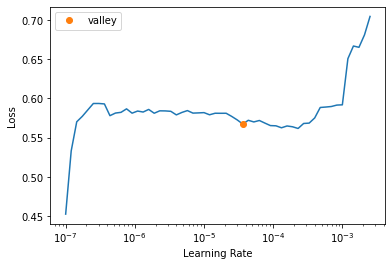

In [101]:
#slow
learn.lr_find()

In [106]:
#slow
learn.fit_one_cycle(5, 4e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.356117,0.474676,0.791461,00:53
1,0.280073,0.417370,0.829228,00:56
2,0.123676,0.630242,0.832512,00:57
3,0.041535,0.737824,0.844007,00:58
4,0.015342,0.750628,0.840723,01:00


In [108]:
#slow
train.label.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [10]:
#hide
!nbdev_build_lib

Converted 00_data.external.ipynb.
Converted 01_task_text_sim.ipynb.


In [12]:
#hide
!git rm 00_core.ipynb index.ip
# !git commit -m "Text Similarity using BertTextCNN as sentence classifiction task."

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
	deleted:    00_core.ipynb
	deleted:    index.ipynb
	modified:   settings.ini

Untracked files:
	Makefile
	docs/_config.yml
	docs/_data/
	nbs/
	nlp/

no changes added to commit


In [ ]:
!git push origin master